In [2]:
# CNN does what it’s good at → images

# MLP does what it’s good at → tabular data

# Model learns complementary information

In [21]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping



In [6]:
df = pd.read_csv(r'Data\Dataset.csv')
df

,id,log-sigma-1-0-mm-3D_glrlm_GrayLevelNonUniformity,log-sigma-1-0-mm-3D_ngtdm_Coarseness,minor_axis_length,area,log-sigma-1-0-mm-3D_gldm_DependenceNonUniformity,log-sigma-2-0-mm-3D_ngtdm_Coarseness,log-sigma-2-0-mm-3D_gldm_DependenceNonUniformity,log-sigma-2-0-mm-3D_glrlm_GrayLevelNonUniformity,wavelet-H_ngtdm_Coarseness,...,wavelet-H_glcm_JointEntropy,wavelet-H_glrlm_GrayLevelNonUniformityNormalized,log-sigma-2-0-mm-3D_glrlm_GrayLevelNonUniformityNormalized,log-sigma-1-0-mm-3D_glrlm_HighGrayLevelRunEmphasis,log-sigma-2-0-mm-3D_glcm_MCC,LBP_hist_bin_7,log-sigma-1-0-mm-3D_gldm_HighGrayLevelEmphasis,label,unexplained_infertility,previous_miscarriages
0,1,4809.535706,0.000247,198.625804,34583,12731.61441,0.000467,13018.03444,2687.906126,0.000138,...,3.863600,0.275603,0.205812,110.158185,0.839618,0.054680,111.058150,0,0,0
1,2,4460.623751,0.000284,193.191790,32053,11900.13194,0.000526,11521.54435,2826.917297,0.000162,...,4.119202,0.252179,0.187636,72.062320,0.853366,0.063489,72.682151,0,0,0
2,3,4925.207181,0.000240,199.327172,34346,13081.91446,0.000431,13580.04041,2784.541071,0.000135,...,3.434695,0.314459,0.231505,56.084546,0.845357,0.060094,56.346329,0,0,0
3,4,4664.352654,0.000257,195.713530,34131,12645.47833,0.000490,12945.91348,2610.770111,0.000141,...,3.599379,0.297244,0.199265,72.034173,0.868814,0.058949,72.831414,0,0,0
4,5,4420.923359,0.000271,196.147021,32842,12027.18696,0.000530,11766.90250,2474.527556,0.000152,...,3.922065,0.272541,0.179913,72.190030,0.855325,0.061050,72.673284,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,124,4568.094233,0.000288,219.654077,39686,14367.67661,0.000472,14273.76697,3055.538006,0.000139,...,3.333863,0.321830,0.175555,90.434190,0.869936,0.069445,90.857481,1,0,1
124,125,4664.626825,0.000275,218.066669,39662,14590.95351,0.000430,14823.92587,3175.472188,0.000136,...,3.076035,0.349690,0.193674,72.112061,0.883472,0.069538,72.611845,1,1,0
125,126,5203.038054,0.000240,229.486021,41192,14904.76695,0.000434,14441.28705,3412.583833,0.000128,...,4.018386,0.262754,0.175031,72.478047,0.846720,0.072174,72.935619,1,0,1
126,127,5362.058473,0.000235,227.372063,40050,14744.51181,0.000405,14445.17743,3592.559575,0.000131,...,4.098497,0.255446,0.195726,110.253146,0.847308,0.059026,110.723695,1,1,0


In [7]:
tabular_features = df.drop(['id', 'label'], axis=1)
labels = df['label']


In [8]:
Scaler = StandardScaler()
x_tabular = Scaler.fit_transform(tabular_features)
y = labels.values

In [9]:
height, width = 256, 256 
batch_size=8

In [13]:
image_folder = r"C:\Users\wesal\OneDrive\Desktop\Junior-fall\Machine Learning\Uterine-Abnormality\Ultrasound-Based-Classification-of-Uterine-Abnormalities\data\images"


image_list = []

for img_id in df['id']:
    img_name = f"{int(img_id):04d}" 
    img_name += '.jpg'
    
    img_path = os.path.join(image_folder, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    if img is None:
        print(f"Warning: image not found -> {img_path}")
        continue
    
    img = img / 255.0
    
    img = img[..., np.newaxis]
    
    image_list.append(img)

X_img = np.array(image_list, dtype=np.float32)
print("Images loaded:", X_img.shape)

Images loaded: (128, 256, 256, 1)


In [14]:
y = labels.values if hasattr(labels, "values") else labels

X_img_train, X_img_val, X_tab_train, X_tab_val, y_train, y_val = train_test_split(
    X_img, x_tabular, y, test_size=0.2, random_state=42, stratify=y
)
print("Training samples:", X_img_train.shape[0])
print("Validation samples:", X_img_val.shape[0])


Training samples: 102
Validation samples: 26


In [15]:
image_input = Input(shape=(256, 256, 1))
x = Conv2D(32, (3,3), activation='relu', padding='same')(image_input)
x = MaxPooling2D((2,2))(x)
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2))(x)
x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)

# MLP for tabular
tab_input = Input(shape=(x_tabular.shape[1],))
y = Dense(128, activation='relu')(tab_input)
y = Dropout(0.3)(y)
y = Dense(64, activation='relu')(y)

#fusion
combined = concatenate([x, y])
z = Dense(64, activation='relu')(combined)
z = Dropout(0.3)(z)
output = Dense(1, activation='sigmoid')(z)

model = Model(inputs=[image_input, tab_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 400)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 131072)    │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     51,328 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │ 16,777,344 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 192)       │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │     12,352 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │         65 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,942,017 (64.63 MB)

 Trainable params: 16,942,017 (64.63 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss', 
    save_best_only=True,  
    verbose=1
)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,       
    restore_best_weights=True,
    verbose=1
)


In [17]:
history = model.fit(
    [X_img_train, X_tab_train],
    y_train,
    validation_data=([X_img_val, X_tab_val], y_val),
    epochs=50,
    batch_size=4,
    callbacks=[checkpoint, early_stop]
)


Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.4870 - loss: 0.7229
Epoch 1: val_loss improved from None to 0.69628, saving model to best_model.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 599ms/step - accuracy: 0.5098 - loss: 0.7029 - val_accuracy: 0.5769 - val_loss: 0.6963
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.5685 - loss: 0.6718
Epoch 2: val_loss did not improve from 0.69628
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 464ms/step - accuracy: 0.5686 - loss: 0.6670 - val_accuracy: 0.5000 - val_loss: 0.7009
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - accuracy: 0.6270 - loss: 0.6362
Epoch 3: val_loss improved from 0.69628 to 0.63591, saving model to best_model.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 13s 492ms/step - accuracy: 0.6667 - loss: 0.6047 - val_accuracy: 0.7308 - val_loss: 0.6359
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.6965 - loss: 0.5322
Epoch 4: val_loss improved from 0.63591 to 0.60373, saving model to best_model.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 13s 496ms/step - accuracy: 0.6765 - loss: 0.5770 - val_accuracy: 0.7308 - val_loss: 0.6037
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.8559 - loss: 0.5311
Epoch 5: val_loss improved from 0.60373 to 0.55996, saving model to best_model.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 15s 588ms/step - accuracy: 0.8039 - loss: 0.5200 - val_accuracy: 0.7308 - val_loss: 0.5600
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.8270 - loss: 0.4343
Epoch 6: val_loss improved from 0.55996 to 0.55955, saving model to best_model.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 614ms/step - accuracy: 0.7549 - loss: 0.4713 - val_accuracy: 0.6923 - val_loss: 0.5596
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.7465 - loss: 0.4444
Epoch 7: val_loss improved from 0.55955 to 0.53443, saving model to best_model.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 527ms/step - accuracy: 0.7843 - loss: 0.4339 - val_accuracy: 0.7308 - val_loss: 0.5344
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.8347 - loss: 0.3838
Epoch 8: val_loss did not improve from 0.53443
26/26 ━━━━━━━━━━━━━━━━━━━━ 17s 372ms/step - accuracy: 0.8235 - loss: 0.4247 - val_accuracy: 0.7308 - val_loss: 0.5762
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.8530 - loss: 0.3972
Epoch 9: val_loss improved from 0.53443 to 0.51563, saving model to best_model.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 424ms/step - accuracy: 0.8039 - loss: 0.4115 - val_accuracy: 0.7308 - val_loss: 0.5156
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.8495 - loss: 0.3014
Epoch 10: val_loss improved from 0.51563 to 0.45697, saving model to best_model.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 431ms/step - accuracy: 0.8529 - loss: 0.3157 - val_accuracy: 0.8077 - val_loss: 0.4570
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.8908 - loss: 0.2943
Epoch 11: val_loss did not improve from 0.45697
26/26 ━━━━━━━━━━━━━━━━━━━━ 16s 233ms/step - accuracy: 0.8922 - loss: 0.2947 - val_accuracy: 0.7308 - val_loss: 0.4631
Epoch 12/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.9703 - loss: 0.1788
Epoch 12: val_loss improved from 0.45697 to 0.43139, saving model to best_model.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 361ms/step - accuracy: 0.9412 - loss: 0.2335 - val_accuracy: 0.8077 - val_loss: 0.4314
Epoch 13/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.9478 - loss: 0.2119
Epoch 13: val_loss improved from 0.43139 to 0.38845, saving model to best_model.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 382ms/step - accuracy: 0.9412 - loss: 0.2069 - val_accuracy: 0.8077 - val_loss: 0.3885
Epoch 14/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.9155 - loss: 0.1896
Epoch 14: val_loss did not improve from 0.38845
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 330ms/step - accuracy: 0.8922 - loss: 0.2327 - val_accuracy: 0.7308 - val_loss: 0.5161
Epoch 15/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.9306 - loss: 0.2320
Epoch 15: val_loss did not improve from 0.38845
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 338ms/step - accuracy: 0.8922 - loss: 0.2420 - val_accuracy: 0.6923 - val_loss: 0.4504
Epoch 16/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9154 - loss: 0.1900
Epoch 16: val_loss did not improve from 0.38845
26/26 ━━━━━━━━━━━━━━━━━━━━ 14s 488ms/step - accuracy: 0.9216 - loss: 0.1803 - val_accuracy: 0.7308 - val_loss: 0.4748
Epoch 17/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.8995 - loss: 0.2577
Epoch 17: val_loss did not improve fro

26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 451ms/step - accuracy: 0.9608 - loss: 0.1243 - val_accuracy: 0.7692 - val_loss: 0.3829
Epoch 21/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.9124 - loss: 0.1446
Epoch 21: val_loss did not improve from 0.38290
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 341ms/step - accuracy: 0.9118 - loss: 0.1516 - val_accuracy: 0.6923 - val_loss: 0.5532
Epoch 22/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.9629 - loss: 0.1167
Epoch 22: val_loss improved from 0.38290 to 0.35721, saving model to best_model.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 383ms/step - accuracy: 0.9510 - loss: 0.1503 - val_accuracy: 0.8077 - val_loss: 0.3572
Epoch 23/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9171 - loss: 0.1980
Epoch 23: val_loss did not improve from 0.35721
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 394ms/step - accuracy: 0.9412 - loss: 0.1457 - val_accuracy: 0.7308 - val_loss: 0.4591
Epoch 24/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.9975 - loss: 0.0709
Epoch 24: val_loss did not improve from 0.35721
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 348ms/step - accuracy: 0.9902 - loss: 0.0698 - val_accuracy: 0.6923 - val_loss: 0.5916
Epoch 25/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.9847 - loss: 0.0747
Epoch 25: val_loss did not improve from 0.35721
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 378ms/step - accuracy: 0.9706 - loss: 0.0979 - val_accuracy: 0.6923 - val_loss: 0.7380
Epoch 26/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.9583 - loss: 0.0750
Epoch 26: val_loss did not improve fr

In [18]:
val_loss, val_acc = model.evaluate([X_img_val, X_tab_val], y_val)
print("Validation accuracy:", val_acc)
y_pred = model.predict([X_img_val, X_tab_val])
y_pred = (y_pred > 0.5).astype(int)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - accuracy: 0.8077 - loss: 0.3572
Validation accuracy: 0.807692289352417
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step


In [19]:
from tensorflow.keras.models import load_model

best_model = load_model('best_model.h5')


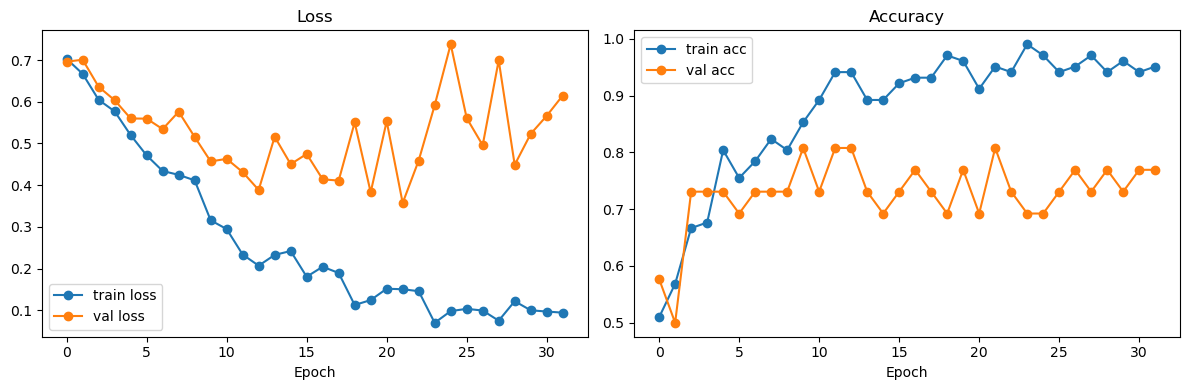

In [22]:
history_dict = history.history
loss = history_dict.get('loss')
val_loss = history_dict.get('val_loss')
acc = history_dict.get('accuracy', history_dict.get('acc'))
val_acc = history_dict.get('val_accuracy', history_dict.get('val_acc'))

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(loss, 'o-', label='train loss')
plt.plot(val_loss, 'o-', label='val loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
if acc is not None and val_acc is not None:
    plt.plot(acc, 'o-', label='train acc')
    plt.plot(val_acc, 'o-', label='val acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
else:
    plt.text(0.5, 0.5, 'No accuracy data in history', ha='center', va='center')

plt.tight_layout()
plt.show()